In [29]:
import pandas as pd
import numpy as np
from itertools import combinations
import math
from scipy import stats
import seaborn as sns


def process_factors_and_response(df, factor_columns, response_column):
    df_encoded = df.copy()

    # Transformar os fatores diretamente em -1 e 1
    for column in factor_columns:
        unique_vals = df_encoded[column].unique()
        mapping = {unique_vals[0]: -1, unique_vals[1]: 1}
        df_encoded[column] = df_encoded[column].map(mapping)

    # Gerar interações
    for r in range(2, len(factor_columns) + 1):
        for combo in combinations(factor_columns, r):
            interaction_col = ''.join(combo)
            df_encoded[interaction_col] = np.prod([df_encoded[factor] for factor in combo], axis=0)

    return df_encoded

def calculate_sst(y):
    y_mean = np.mean(y)
    SST = np.sum((y - y_mean) ** 2)
    return SST

def calculate_effects_corrected(df_encoded, y_means, response_column):
    effects = {}
    num_experiments = len(y_means)

    for factor in df_encoded.columns:
        if factor in factor_columns or not any(metric in factor for metric in ['accuracy', 'precision', 'recall', 'f1']):
            effect = np.sum(df_encoded[factor].values * y_means) / num_experiments
            effects[factor] = effect

    return effects

def calculate_sse(y, y_means):
    SSE = np.sum((y - y_means[:, np.newaxis]) ** 2)
    return SSE

def calculate_mse(SSE, num_experiments):
    # Mean Squared Error (MSE)
    MSE = SSE / (num_experiments - 1)
    return MSE

def allocate_variation(effects, SST, num_experiments):
    variation_explained = {}

    for factor, effect in effects.items():
        SS_factor = num_experiments * (effect ** 2)
        variation_explained[factor] = (SS_factor / SST)*1000

    return variation_explained

def calculate_confidence_intervals(effects, mse, num_replicates, confidence=0.90):
    # t-distribution critical value for the specified confidence interval
    dof = num_replicates - 1  # degrees of freedom
    t_value = stats.t.ppf((1 + confidence) / 2, dof)

    confidence_intervals = {}

    for factor, effect in effects.items():
        # Calcular erro padrão com base no MSE
        standard_error = np.sqrt(mse / num_replicates)

        # Calcular margem de erro
        margin_of_error = t_value * standard_error

        # Limites do intervalo de confiança
        lower_bound = effect - margin_of_error
        upper_bound = effect + margin_of_error
        mean_effect = effect

        confidence_intervals[factor] = {
            'lower': lower_bound,
            'upper': upper_bound,
            'mean': mean_effect
        }

    return confidence_intervals


def perform_analysis_corrected(df, factor_columns, response_columns):
    df_encoded = process_factors_and_response(df, factor_columns, response_columns)

    y = df[response_columns].values
    y_means = np.mean(y, axis=1)

    SST = calculate_sst(y.flatten())
    SSE = calculate_sse(y, y_means)
    MSE = calculate_mse(SSE, len(df_encoded))

    effects = calculate_effects_corrected(df_encoded, y_means, response_columns)

    num_experiments = len(df_encoded)
    variation_explained = allocate_variation(effects, SST, num_experiments)

    # Normalizando variações
    total_variation_explained = sum(variation_explained.values())
    experimental_error_percentage = (SSE / SST) * 100

    # Calcular intervalos de confiança para os efeitos
    confidence_intervals = calculate_confidence_intervals(effects, MSE, len(df_encoded))

    # Exibe os resultados
    print("\nTabela de Fatores e Interações:")
    print(df_encoded)

    print(f"\nSoma Total dos Quadrados (SST): {SST}")
    print(f"Soma dos Quadrados do Erro (SSE): {SSE}")
    print(f"Erro Quadrático Médio (MSE): {MSE}")
    print(f"Desvio Padrão dos Erros: {np.sqrt(MSE)}")

    print("\nEfeitos dos Fatores e Interações:")
    for factor, effect in effects.items():
        print(f"  {factor}: {effect:.4f}")

    print("\nIntervalos de Confiança para os Efeitos:")
    for factor, ci in confidence_intervals.items():
      print(f"{factor}: [{ci['lower']:.4f}, {ci['mean']:.4f}, {ci['upper']:.4f}]")


    print("\nVariação Explicada por Cada Fator e Interação:")
    for factor, variation in variation_explained.items():
        print(f"  {factor}: {variation:.2f}%")

    print(f"\nPorcentagem de Erros Experimentais: {experimental_error_percentage:.2f}%")

    print(f"\nSoma Total das Variações Explicadas: {total_variation_explained - experimental_error_percentage:.2f}%")
    print(f"Soma Total da Variação (incluindo Erro Experimental): {total_variation_explained + experimental_error_percentage:.2f}%")

    return effects, confidence_intervals, variation_explained


# Função para obter os efeitos mais significativos
def get_significant_effects(effects, confidence_intervals):
    significant_effects = {}
    for factor, ci in confidence_intervals.items():
        lower, upper = ci['lower'], ci['upper']
        if lower > 0 or upper < 0:  # Considera significativo se o intervalo não incluir zero
            significant_effects[factor] = {
                'mean': ci['mean'],
                'lower': lower,
                'upper': upper
            }
    return significant_effects

# Nova função para análise e gráfico de interação
def perform_analysis_and_plot_interaction(df, factor_columns, response_columns):
    # Executa a análise
    effects, confidence_intervals, variation_explained = perform_analysis_corrected(df, factor_columns, response_columns)

    # Determina os dois fatores mais influentes com base na variação explicada
    sorted_variation = sorted(variation_explained.items(), key=lambda item: abs(item[1]), reverse=True)
    top_factors = [factor for factor, _ in sorted_variation[:2]]

    print(f"\nOs dois fatores mais influentes são: {top_factors}")

    # Gera o gráfico de interação entre os dois fatores mais influentes
    plot_interaction(df, top_factors[0], top_factors[1], response_columns[0])  # Usando a primeira métrica como proxy para a resposta


# Função para gerar gráfico de interação
def plot_interaction(df, factor_1, factor_2, response_column):
    """
    Gera um gráfico de interação entre dois fatores.
    """
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))

    # Plotar a interação usando Seaborn
    sns.pointplot(x=factor_1, y=response_column, hue=factor_2, data=df, dodge=True, markers=["o", "s"], linestyles=["-", "--"])

    plt.title(f'Gráfico de Interação: {factor_1} e {factor_2}')
    plt.xlabel(factor_1)
    plt.ylabel(response_column)
    plt.legend(title=factor_2)
    plt.grid(True)
    plt.show()




Analisando o grupo de resposta: accuracy

Tabela de Fatores e Interações:
   window_size  sample_frac  calc_type  accuracy_1  precision_1  recall_1  \
0           -1           -1         -1    0.823266     0.667142  0.749493   
1           -1           -1          1    0.819136     0.671894  0.705441   
2           -1            1         -1    0.839642     0.687591  0.794300   
3           -1            1          1    0.834173     0.691125  0.748680   
4            1           -1         -1    0.832221     0.687093  0.747693   
5            1           -1          1    0.818666     0.684129  0.667471   
6            1            1         -1    0.857598     0.719276  0.814891   
7            1            1          1    0.836991     0.700847  0.739837   

       f1_1  accuracy_2  precision_2  recall_2  ...  recall_mean  recall_std  \
0  0.705924    0.821586     0.665052  0.744640  ...     0.748004    0.003963   
1  0.688259    0.810751     0.663719  0.671594  ...     0.695205    0.0

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


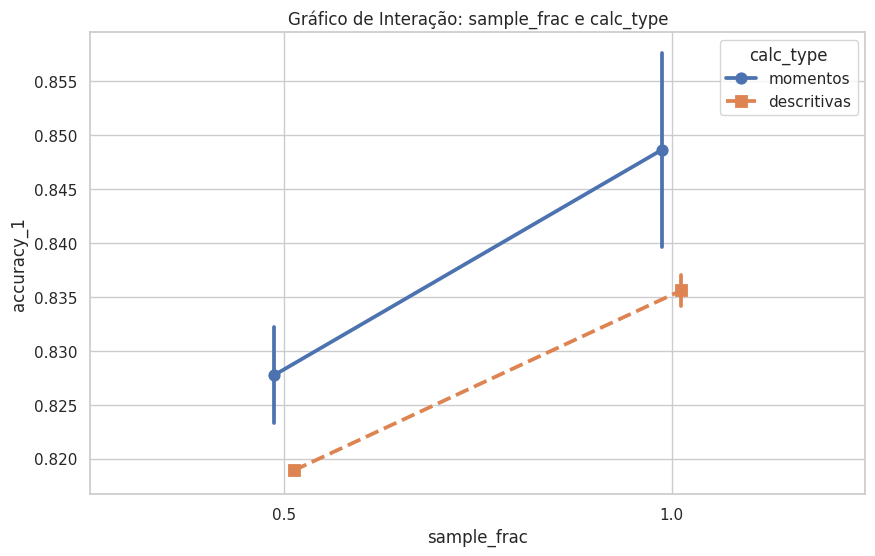


Analisando o grupo de resposta: precision

Tabela de Fatores e Interações:
   window_size  sample_frac  calc_type  accuracy_1  precision_1  recall_1  \
0           -1           -1         -1    0.823266     0.667142  0.749493   
1           -1           -1          1    0.819136     0.671894  0.705441   
2           -1            1         -1    0.839642     0.687591  0.794300   
3           -1            1          1    0.834173     0.691125  0.748680   
4            1           -1         -1    0.832221     0.687093  0.747693   
5            1           -1          1    0.818666     0.684129  0.667471   
6            1            1         -1    0.857598     0.719276  0.814891   
7            1            1          1    0.836991     0.700847  0.739837   

       f1_1  accuracy_2  precision_2  recall_2  ...  recall_mean  recall_std  \
0  0.705924    0.821586     0.665052  0.744640  ...     0.748004    0.003963   
1  0.688259    0.810751     0.663719  0.671594  ...     0.695205    0.

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


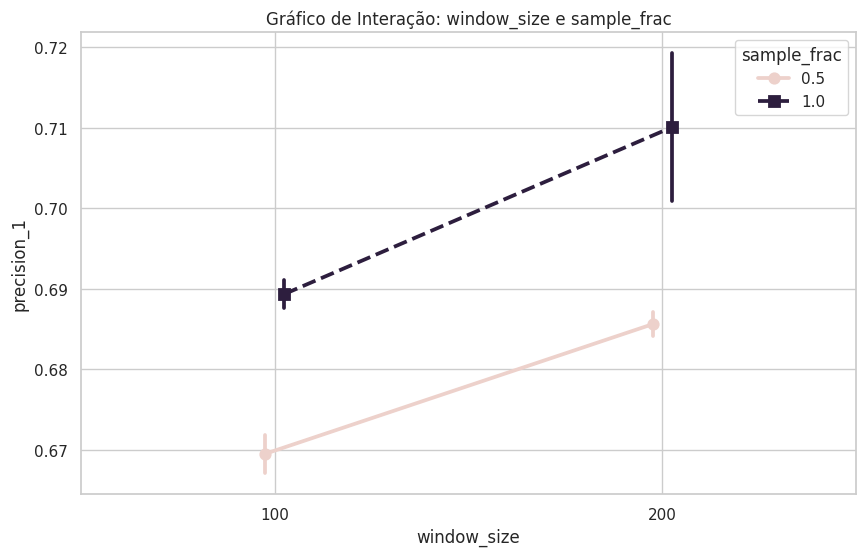


Analisando o grupo de resposta: recall

Tabela de Fatores e Interações:
   window_size  sample_frac  calc_type  accuracy_1  precision_1  recall_1  \
0           -1           -1         -1    0.823266     0.667142  0.749493   
1           -1           -1          1    0.819136     0.671894  0.705441   
2           -1            1         -1    0.839642     0.687591  0.794300   
3           -1            1          1    0.834173     0.691125  0.748680   
4            1           -1         -1    0.832221     0.687093  0.747693   
5            1           -1          1    0.818666     0.684129  0.667471   
6            1            1         -1    0.857598     0.719276  0.814891   
7            1            1          1    0.836991     0.700847  0.739837   

       f1_1  accuracy_2  precision_2  recall_2  ...  recall_mean  recall_std  \
0  0.705924    0.821586     0.665052  0.744640  ...     0.748004    0.003963   
1  0.688259    0.810751     0.663719  0.671594  ...     0.695205    0.011

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


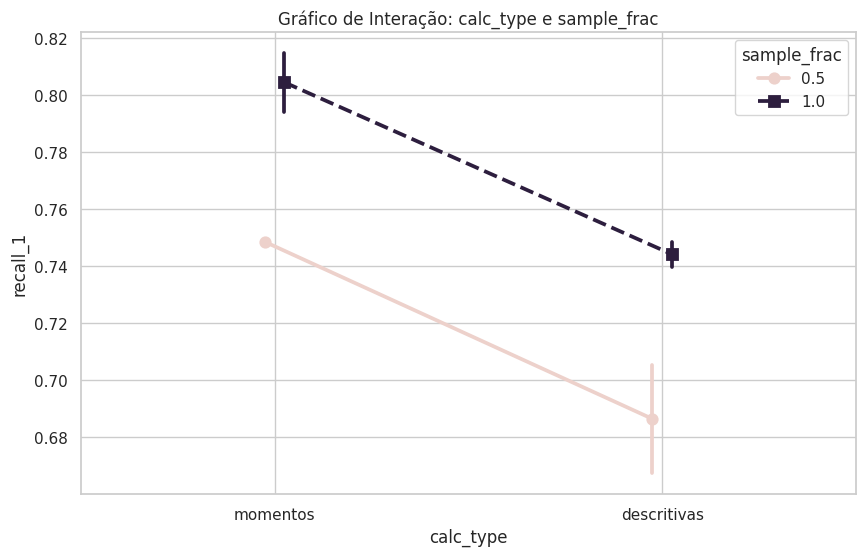


Analisando o grupo de resposta: f1

Tabela de Fatores e Interações:
   window_size  sample_frac  calc_type  accuracy_1  precision_1  recall_1  \
0           -1           -1         -1    0.823266     0.667142  0.749493   
1           -1           -1          1    0.819136     0.671894  0.705441   
2           -1            1         -1    0.839642     0.687591  0.794300   
3           -1            1          1    0.834173     0.691125  0.748680   
4            1           -1         -1    0.832221     0.687093  0.747693   
5            1           -1          1    0.818666     0.684129  0.667471   
6            1            1         -1    0.857598     0.719276  0.814891   
7            1            1          1    0.836991     0.700847  0.739837   

       f1_1  accuracy_2  precision_2  recall_2  ...  recall_mean  recall_std  \
0  0.705924    0.821586     0.665052  0.744640  ...     0.748004    0.003963   
1  0.688259    0.810751     0.663719  0.671594  ...     0.695205    0.011027 

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


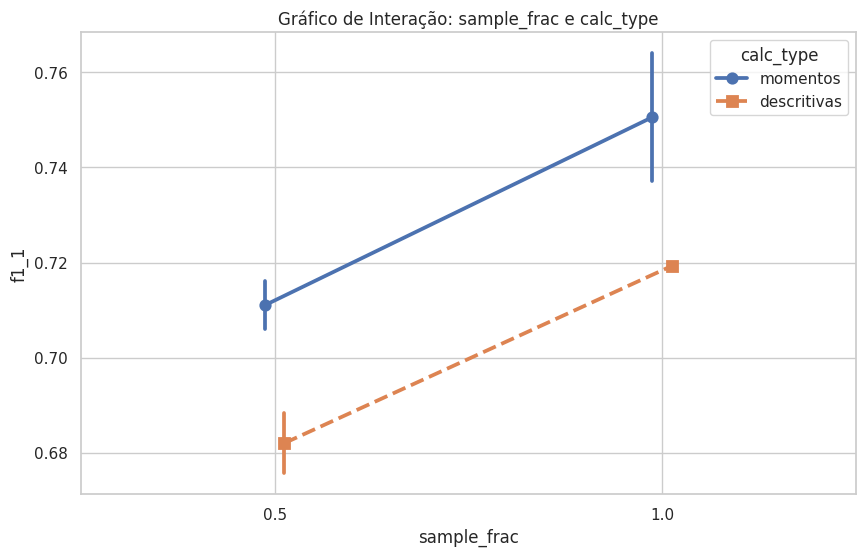

In [32]:
# Carregar os dados do CSV
file_path = "experiment_results_mean_2.csv"
df = pd.read_csv(file_path).drop('experiment_id', axis=1)
factor_columns = ['window_size', 'sample_frac', 'calc_type']

# Analisar o grupo de respostas
response_groups = [
    [f'accuracy_{i}' for i in range(1, 11)],
    [f'precision_{i}' for i in range(1, 11)],
    [f'recall_{i}' for i in range(1, 11)],
    [f'f1_{i}' for i in range(1, 11)]
]

for response_group in response_groups:
    metric_name = response_group[0].split('_')[0]
    print(f"\nAnalisando o grupo de resposta: {metric_name}")

    # Obter efeitos, intervalos de confiança e variações
    effects, confidence_intervals, variation_explained = perform_analysis_corrected(df, factor_columns, response_group)

    # Média do modelo
    model_mean = np.mean(df[response_group].values)

    # Obter os efeitos mais significativos
    significant_effects = get_significant_effects(effects, confidence_intervals)

    # Gerar o gráfico de interação entre os dois fatores mais influentes
    perform_analysis_and_plot_interaction(df, factor_columns, response_group)